# PMC ABC

attempt 2

In [12]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

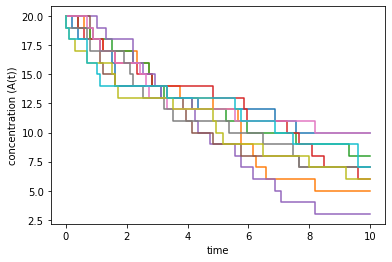

In [13]:
np.random.seed(3)
# Load a forward model
model = toy.StochasticDegradationModel()
# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 10, 100)
for i in range(10):
    values = model.simulate(real_parameters, times)
    # Create an object with links to the model and time series
    problem = pints.SingleOutputProblem(model, times, values)
    # Create a uniform prior parameter
    log_prior = pints.UniformLogPrior([0.0], [0.3])
    # Set the error measure to be used to compare simulated to observed data
    error_measure = pints.RootMeanSquaredError(problem)
    plt.step(times, values)

plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

In [17]:
np.random.seed(2)

abc = pints.ABCController(error_measure, log_prior, method=pints.ABCPMC)

# set threshold
abc.sampler().set_threshold(1)

# set target number of samples
abc.set_n_samples(200)

# parallel needs to be enabled for PMC
abc.set_parallel(True)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using Rejection ABC
Running in parallel with 8 worker processess.
initializing weights to 0.125
sending [[0.0898964]] for vibe check
finished tell
sending [[0.18982132]] for vibe check
finished tell
sending [[0.15874263]] for vibe check
finished tell
sending [[0.14956835]] for vibe check
finished tell
sending [[0.05533196]] for vibe check
finished tell
sending [[0.07754943]] for vibe check
finished tell
sending [[0.14827105]] for vibe check
finished tell
sending [[0.05309539]] for vibe check
w_sum ** 2 = 1.0 whereas w_sq_sum = 0.125
finished tell
received cov 0.008088220752599256 with n=8
first branch
sending [array([0.14863003])] for vibe check
finished tell
received cov 0.008088220752599256 with n=8
first branch
sending [array([0.08422148])] for vibe check
finished tell
received cov 0.008088220752599256 with n=8
first branch
sending [array([0.14682788])] for vibe check
finished tell
received cov 0.008088220752599256 with n=8
first branch
sending [array([0.14765804])] for v

D:\Part B\python\lib\site-packages\pints\_abc\_abc_pmc.py:168: RuntimeWarning: divide by zero encountered in double_scalars
  self._n_weights[self._i] = (self._log_prior(self._n_theta[self._i]) / norm_term)



finished tell
received cov 0.0011007490686681342 with n=8
first branch
sending [array([0.14379907])] for vibe check
finished tell
received cov 0.0011007490686681342 with n=8
first branch
sending [array([0.08144979])] for vibe check
finished tell
received cov 0.0011007490686681342 with n=8
first branch
sending [array([0.16289547])] for vibe check
finished tell
received cov 0.0011007490686681342 with n=8
first branch
sending [array([0.14851372])] for vibe check
finished tell
received cov 0.0011007490686681342 with n=8
first branch
sending [array([0.08525456])] for vibe check
finished tell
received cov 0.0011007490686681342 with n=8
first branch
sending [array([0.08327572])] for vibe check
finished tell
received cov 0.0011007490686681342 with n=8
first branch
sending [array([0.16291774])] for vibe check
finished tell
received cov 0.0011007490686681342 with n=8
first branch
sending [array([0.16086769])] for vibe check
finished tell
received cov 0.0011007490686681342 with n=8
first branch
